In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Activation, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
def unet_down_block(x, n_filters, block_id, with_maxpool=True, activation="elu"):
    y = Conv2D(n_filters, (3, 3), activation=activation, 
               padding='valid', name="conv{}_1".format(block_id))(x)
    y = BatchNormalization(name="bn{}_1".format(block_id))(y)
    
    y = Conv2D(n_filters, (3, 3), activation=activation,
               padding='valid', name="conv{}_2".format(block_id))(y)
    conv = BatchNormalization(name="bn{}_2".format(block_id))(y)
    
    if not with_maxpool:
        return conv
    
    pool = MaxPooling2D(pool_size=(2, 2), name="max_pool{}".format(block_id))(conv)   
    return conv, pool    

In [7]:
def unet_up_block(x, y, n_filters, block_id, activation="elu"):
    up_x = UpSampling2D(size=(2, 2))(x)
    
    # Compute crop needed to have the same shape for up_x and y
    _, hx, wx, _ = up_x.shape
    _, hy, wy, _ = y.shape
    cropy = int(hy - hx)//2
    cropx = int(wy - wx)//2
    crop_y = Cropping2D(cropping=((cropy, cropy), (cropx, cropx)))(y)
    
    up = concatenate([up_x, crop_y], axis=-1)
    up = Conv2D(n_filters, (3, 3), activation=activation, padding='valid')(up)
    up = Conv2D(n_filters, (3, 3), activation=activation, padding='valid')(up)
    
    return up

In [8]:
def get_unet(im_height, im_width, n_channels=3, n_classes=6,
             n_filters=[64, 128, 256, 512, 1024]):
    inputs = Input((im_height, im_width, n_channels))
    
    conv1, pool1 = unet_down_block(inputs, n_filters[0], 1)
    conv2, pool2 = unet_down_block(pool1,  n_filters[1], 2)
    conv3, pool3 = unet_down_block(pool2,  n_filters[2], 3)
    conv4, pool4 = unet_down_block(pool3,  n_filters[3], 4)
    conv5 = unet_down_block(pool4, n_filters[4], 5, with_maxpool=False)
    
    conv6 = unet_up_block(conv5, conv4, n_filters[3], 6)
    conv7 = unet_up_block(conv6, conv3, n_filters[2], 7)
    conv8 = unet_up_block(conv7, conv2, n_filters[1], 8)
    conv9 = unet_up_block(conv8, conv1, n_filters[0], 9)
    
    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [9]:
unet = get_unet(396, 396, 3, n_filters=[32, 64, 128, 256, 512])

In [10]:
t = np.ones((1, 396, 396, 3))
unet.predict(t).shape

(1, 212, 212, 6)

In [11]:
(396-212)/2

92.0

In [12]:
unet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 396, 396, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 394, 394, 32)  896                                          
____________________________________________________________________________________________________
bn1_1 (BatchNormalization)       (None, 394, 394, 32)  128                                          
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 392, 392, 32)  9248                                         
___________________________________________________________________________________________

In [13]:
class NonValidPatch(Exception):
    pass

In [14]:
def get_block_loc(shape, x, y, target_size=(396, 396), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [15]:
def to_img(smap):
    colors_rgb = [(1, 7, 179), (178, 12, 178), (5, 41, 79), (177, 54, 26), (26, 171, 43)]
    im = np.zeros(smap.shape + (3, ), dtype=np.uint8)
    for i in range(5):
        im[smap==i, :] = colors_rgb[i]
    return im

In [16]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(396, 396),
                 crop = (92, 92),
                 batch_size=8, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 4
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.crop = crop
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def compute_class_distribution(self, n_batches):
        total = 0
        count_per_classes = defaultdict(int)
        for b in range(n_batches):
            _, by = self.next()
            by = np.argmax(by, axis=-1)
            ids, counts = np.unique(by, return_counts=True)
            for i in range(ids.shape[0]):
                count_per_classes[ids[i]] += counts[i]
                total += counts[i]
            
        class_counts = []
        for i in range(self.n_sealion_types + 1):
            class_counts.append(count_per_classes[i])
        return class_counts

    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y

    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with pups in it
            return self.sample_bg(shape), output_class
        else:
            return self.sample_dot(shape, dots[output_class]), output_class
                     
    def get_dots_in_block(self, bid, shape, dots, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    smap = np.load(os.path.join(self.root_dir, "TrainSegmentation", uid + ".npz"))['smap']
                    return bid, img, smap
            except NonValidPatch:
                continue
    
    def sample(self, shape, dots, image_id):        
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img, smap = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, self.target_size[0] - 2 * self.crop[0], self.target_size[1] - 2 * self.crop[1]))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths)
                    img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    smap_patch = smap[y:y+self.target_size[0], x:x+self.target_size[1]]
                    img_patch, smap_patch = self.random_transform(img_patch, smap_patch)             
                    smap_crop = smap_patch[self.crop[0]:-self.crop[0], self.crop[1]:-self.crop[1]]
                    
                    bx[n_samples, ...] = img_patch
                    by[n_samples, ...] = smap_crop
                    n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
    def sample_bg(self, shape):
        """ Just sample a random patch
        """
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, dots):
        """ Sample so that a random selected sealion is fully inside the patch
        """
        half_size = max(self.crop[0], self.crop[1]) + 40
        
        randi = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0] - 2 * self.crop[0],
                            self.target_size[1] - 2 * self.crop[1]),
                           dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 

        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                cv2.imwrite(os.path.join(self.debug_dir, "smap_{}.jpg".format(i)), to_img(batch_y[i]))
                
        permut = np.random.permutation(batch_x.shape[0])
        b, h, w = batch_y.shape
        batch_y = to_categorical(batch_y[permut,...], num_classes=self.n_sealion_types + 1)
        return self.normalize_input(batch_x[permut, ...]), batch_y.reshape((b, h, w, self.n_sealion_types + 1))

In [17]:
with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [18]:
class_weights = [1, 1, 1, 1, 1, 1/20]

In [19]:
trainPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", train_ids, class_weights)

In [20]:
valPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", val_ids, class_weights)

In [21]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [22]:
batch_x.shape

(8, 396, 396, 3)

In [23]:
batch_y.shape

(8, 212, 212, 6)

In [24]:
bpred = unet.predict(batch_x)

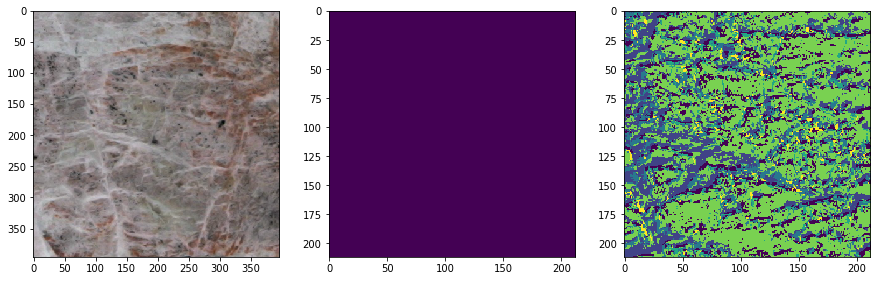

In [25]:
i = 7
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(bpred[i,...], axis=-1))

In [26]:
classes_counts = trainPatchesGenerator.compute_class_distribution(100)

In [27]:
classes_counts

[218210, 142099, 1265131, 626510, 67343, 33635907]

In [28]:
mcount = np.median(classes_counts)

In [29]:
weights_per_class = mcount/classes_counts

In [30]:
weights_per_class

array([ 1.93556666,  2.97229396,  0.33384685,  0.67414726,  6.27177286,
        0.01255682])

In [33]:
def w_categorical_crossentropy(y_true, y_pred):
    y_true_r = K.reshape(y_true, (8, 212*212, 6))
    y_pred_r = K.reshape(y_pred, (8, 212*212, 6))
    weights = K.max(y_true_r * weights_per_class, axis=-1)
    loss_per_pixel = K.categorical_crossentropy(y_pred_r, y_true_r)
    return loss_per_pixel * weights

In [34]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation/log_tb", batch_freq=10)

In [35]:
sgd = SGD(lr=1e-2, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=w_categorical_crossentropy, metrics=["accuracy"])

In [36]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/20
1000/1000 [==============================] - 1049s - loss: 0.1048 - acc: 0.5982 - val_loss: 0.1108 - val_acc: 0.7439
Epoch 2/20
1000/1000 [==============================] - 1042s - loss: 0.0902 - acc: 0.7047 - val_loss: 0.1025 - val_acc: 0.7674
Epoch 3/20
1000/1000 [==============================] - 1041s - loss: 0.0805 - acc: 0.7202 - val_loss: 0.0920 - val_acc: 0.8224
Epoch 4/20
1000/1000 [==============================] - 1042s - loss: 0.0776 - acc: 0.7522 - val_loss: 0.0771 - val_acc: 0.7966
Epoch 5/20
1000/1000 [==============================] - 1041s - loss: 0.0768 - acc: 0.7617 - val_loss: 0.0848 - val_acc: 0.8245
Epoch 6/20
1000/1000 [==============================] - 1045s - loss: 0.0787 - acc: 0.7734 - val_loss: 0.0935 - val_acc: 0.8442
Epoch 7/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.7735
Epoch 00006: reducing learning rate to 0.0009999999776482583.
1000/1000 [==============================] - 1047s - loss: 0.0736 - acc: 0.77

KeyboardInterrupt: 

In [72]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=10,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/10
1000/1000 [==============================] - 1046s - loss: 0.0697 - acc: 0.8141 - val_loss: 0.0646 - val_acc: 0.8716
Epoch 2/10
1000/1000 [==============================] - 1040s - loss: 0.0661 - acc: 0.8207 - val_loss: 0.0696 - val_acc: 0.8616
Epoch 3/10
1000/1000 [==============================] - 1039s - loss: 0.0634 - acc: 0.8293 - val_loss: 0.0787 - val_acc: 0.8608
Epoch 4/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.8262
Epoch 00003: reducing learning rate to 9.999999310821295e-05.
1000/1000 [==============================] - 1037s - loss: 0.0655 - acc: 0.8262 - val_loss: 0.0762 - val_acc: 0.8682
Epoch 5/10
1000/1000 [==============================] - 1042s - loss: 0.0635 - acc: 0.8374 - val_loss: 0.0762 - val_acc: 0.8562
Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.8327
Epoch 00005: reducing learning rate to 9.999999019782991e-06.
1000/1000 [==============================] - 1042s - loss: 0.

KeyboardInterrupt: 

In [73]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [74]:
bpred = unet.predict(batch_x)

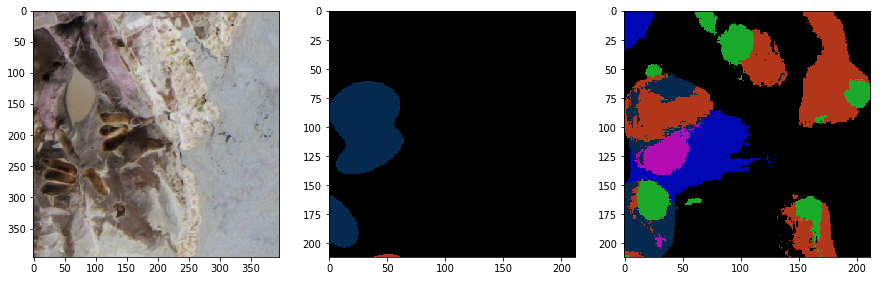

In [90]:
i = 5
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(to_img(np.argmax(batch_y[i,...], axis=-1)))
plt.subplot(133)
plt.imshow(to_img(np.argmax(bpred[i,...], axis=-1)))

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")